# Clustering of neighborhoods in Taipei city by using Foursquare data

## Introduction/Business Problem

>Taipei, located in Northern Taiwan, is the capital and a special municipality of Taiwan. The city proper is home to approximately 2,7 million people, which makes a population density of nearly 10,000 people per square kilometer . 
Taiwan is my favorite country for spending my vacations due to a number of reasons: its subtropical climate, friendly and hospitable people, plenty of tourist attractions of various types, well-connected public transports, and irresistible Taiwanese cuisine. Beijing the political, economic, educational and cultural center of Taiwan, Taipei attracts millions of overseas visitors each year, making it the 15th most visited city globally, and the most of any city in the Chinese-speaking world.

>However, despite the large amount of travel guides and recommendations, it is not that easy for people who are new to the city to makes decisions on the best places to stay for their first visits. Depending on different purposes and duration, visitors may have various preferences and requirements, for instance, some needs easy access to major transportation centers for convenience, some prefers to stay in a quiet place far from the city center, some wants to be close to the commercial centers, while others prefer to stay in an area where one gets most authentic experience of local life etc. After I have been to Taipei many times, my friends and relatives have for several times asked me for advice regarding visiting the different parts of Taipei city.

>To accommodate this need, I decided to create a map of Taipei that visualize the characteristics of different clusters of neighborhoods in Taipei city, which provides new visitors a quick overview of distribution of different areas in Taipei city.

## Data

>Considering the above stated problem, I will use the following data to create the target map.

>- List of the administrative districts of Taipei City with postal codes – scraped from [this Wiki page](https://en.wikipedia.org/wiki/Postal_codes_in_Taiwan). The data is in the second table from this page.
>- Use geopy to get location coordinates of Taipei city and its administrative districts listed above. 
>- Use Foursquare API to explore popular venues in each Taipei district. I’ll be querying the top 200 venues in each district in a radius of 1000m radius as it is a reasonable walking distance. The result will be analyzed to get the top venue categories for each district, which then will be used to cluster the districts. 

In [1]:
import pandas as pd # library for data analysis
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents

In [2]:
# get the data of districts and post codes from Wiki
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/Postal_codes_in_Taiwan#Classification%20of%20postal%20codes"
response=requests.get(wikiurl)

In [3]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
taiwantables=soup.find_all('table',{'class':"wikitable"})
taipeitable=taiwantables[1]

In [4]:
# covert list to dataframe
taipei_df=pd.read_html(str(taipeitable))
taipei_df=pd.DataFrame(taipei_df[0])
taipei_df.head()

,Code,Division name,Chinese
,Taipei City,Taipei City,Taipei City
0,100,Zhongzheng District,中正區
1,103,Datong District,大同區
2,104,Zhongshan District,中山區
3,105,Songshan District,松山區
4,106,Daan District,大安區


In [5]:
taipei_df.columns

MultiIndex([(         'Code', 'Taipei City'),
            ('Division name', 'Taipei City'),
            (      'Chinese', 'Taipei City')],
           )

In [6]:
# change multiIndex to flat index
taipei_df.columns = taipei_df.columns.get_level_values(0)

In [7]:
taipei_df

,Code,Division name,Chinese
0,100,Zhongzheng District,中正區
1,103,Datong District,大同區
2,104,Zhongshan District,中山區
3,105,Songshan District,松山區
4,106,Daan District,大安區
5,108,Wanhua District,萬華區
6,110,Xinyi District,信義區
7,111,Shilin District,士林區
8,112,Beitou District,北投區
9,114,Neihu District,內湖區


In [8]:
# remove unnecessary column and change column names to "Postal code" and "Neighborhood"
taipei_df=taipei_df.drop(['Chinese'], axis=1).rename(columns={'Code':'Postal code', 'Division name':'Neighborhood'})
taipei_df.head(5)

,Postal code,Neighborhood
0,100,Zhongzheng District
1,103,Datong District
2,104,Zhongshan District
3,105,Songshan District
4,106,Daan District


## Get coordinates for Teipei City and its neighborhoods

In [9]:
!pip install geopy 

In [10]:
from geopy.geocoders import Nominatim
address = 'Taipei City, TW'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Taipei City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Taipei City are 25.0375198, 121.5636796.


In [11]:
address = 'Zhongzheng District, TW'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Zhongzheng District are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Zhongzheng District are 25.0323611, 121.518267.


In [12]:
address = (taipei_df['Neighborhood'].values + ', TW').tolist()
latitude = []
longitude = []

for address in address:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude.append(location.latitude) 
    longitude.append(location.longitude)

In [13]:
taipei_df['Latitude'] = latitude
taipei_df['Longitude'] = longitude
taipei_df

,Postal code,Neighborhood,Latitude,Longitude
0,100,Zhongzheng District,25.032361,121.518267
1,103,Datong District,25.065986,121.515514
2,104,Zhongshan District,25.064361,121.533468
3,105,Songshan District,25.049885,121.577272
4,106,Daan District,25.026515,121.534395
5,108,Wanhua District,25.031933,121.499332
6,110,Xinyi District,25.033345,121.566896
7,111,Shilin District,25.091840,121.524207
8,112,Beitou District,25.131931,121.498593
9,114,Neihu District,25.069664,121.588998


### Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = 'LAFC0ZZQTJUXNJ1M5STCDWVTLKTHT2VDUDESH4RXTTR0341P' 
CLIENT_SECRET = 'ATW50H3ZDDI3LPVJHIDCSAI0UHMCJMV5QEYKYQMX3BH453SR' 
VERSION = '20210123' 
LIMIT = 200 

#### Explore the first neighborhood

In [15]:
taipei_df.loc[0, 'Neighborhood']

'Zhongzheng District'

#### Get the top 200 venues that are in Zhongzheng Distrct within a radius of 1000 meters

In [16]:
zhongzheng_lat = taipei_df.loc[0, 'Latitude']
zhongzheng_long = taipei_df.loc[0, 'Longitude']
radius = 1000

url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, zhongzheng_lat, zhongzheng_long, VERSION, radius, LIMIT)


#### Send GET request and examine the results

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60221a7d0149401628975c1f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Zhōngzhèng Qū',
  'headerFullLocation': 'Zhōngzhèng Qū, Taipei',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 120,
  'suggestedBounds': {'ne': {'lat': 25.041361109000007,
    'lng': 121.52818148278706},
   'sw': {'lat': 25.02336109099999, 'lng': 121.50835251721293}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b8e4566f964a520891d33e3',
       'name': 'Kinfen Braised Pork Rice (金峰魯肉飯)',
       'location': {'address': '羅斯福路一段10號',
        'lat': 25.03219410314086,
        'lng': 121.51853364691742,
        'labeledLatLngs': [{'label': 'display',
  

#### Create a function that extracts the category of the venue

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Kinfen Braised Pork Rice (金峰魯肉飯),Taiwanese Restaurant,25.032194,121.518534
1,National Theater (國家戲劇院),Theater,25.035197,121.518188
2,樂田麵包屋 Gakuden Boulangerie,Bakery,25.032757,121.517534
3,虎記商行,Café,25.031744,121.519284
4,Chiang Kai-Shek Memorial Hall (中正紀念堂),Monument / Landmark,25.034555,121.521835


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


#### Create a function to repeat the same process to all the neighborhoods in Taipei

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
taipei_venues = getNearbyVenues(names=taipei_df['Neighborhood'],
                                   latitudes=taipei_df['Latitude'],
                                   longitudes=taipei_df['Longitude']
                                  )

Zhongzheng District
Datong District
Zhongshan District
Songshan District
Daan District
Wanhua District
Xinyi District
Shilin District
Beitou District
Neihu District
Nangang District
Wenshan District


In [23]:
print(taipei_venues.shape)
taipei_venues.head()

(886, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Zhongzheng District,25.032361,121.518267,Kinfen Braised Pork Rice (金峰魯肉飯),25.032194,121.518534,Taiwanese Restaurant
1,Zhongzheng District,25.032361,121.518267,National Theater (國家戲劇院),25.035197,121.518188,Theater
2,Zhongzheng District,25.032361,121.518267,樂田麵包屋 Gakuden Boulangerie,25.032757,121.517534,Bakery
3,Zhongzheng District,25.032361,121.518267,虎記商行,25.031744,121.519284,Café
4,Zhongzheng District,25.032361,121.518267,Chiang Kai-Shek Memorial Hall (中正紀念堂),25.034555,121.521835,Monument / Landmark


In [24]:
taipei_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Beitou District,56,56,56,56,56,56
Daan District,100,100,100,100,100,100
Datong District,99,99,99,99,99,99
Nangang District,54,54,54,54,54,54
Neihu District,28,28,28,28,28,28
Shilin District,75,75,75,75,75,75
Songshan District,66,66,66,66,66,66
Wanhua District,69,69,69,69,69,69
Wenshan District,39,39,39,39,39,39


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
venues_number=taipei_venues.groupby('Neighborhood').count()
venues_number

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Beitou District,56,56,56,56,56,56
Daan District,100,100,100,100,100,100
Datong District,99,99,99,99,99,99
Nangang District,54,54,54,54,54,54
Neihu District,28,28,28,28,28,28
Shilin District,75,75,75,75,75,75
Songshan District,66,66,66,66,66,66
Wanhua District,69,69,69,69,69,69
Wenshan District,39,39,39,39,39,39


In [27]:
venues_number=venues_number[['Venue Category']].reset_index()
venues_number

,Neighborhood,Venue Category
0,Beitou District,56
1,Daan District,100
2,Datong District,99
3,Nangang District,54
4,Neihu District,28
5,Shilin District,75
6,Songshan District,66
7,Wanhua District,69
8,Wenshan District,39
9,Xinyi District,100


In [28]:
import seaborn as sns

Text(0, 0.5, 'Neighborhood')

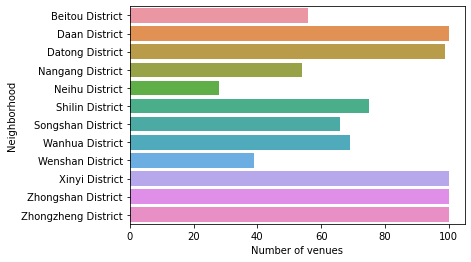

In [29]:
ax = sns.barplot(x='Venue Category', y='Neighborhood', data=venues_number)
plt.xlabel('Number of venues')
plt.ylabel('Neighborhood')

In [30]:
print('There are {} uniques categories.'.format(len(taipei_venues['Venue Category'].unique())))

There are 153 uniques categories.


In [31]:
# one hot encoding
taipei_onehot = pd.get_dummies(taipei_venues[['Venue Category']], prefix="", prefix_sep="")
taipei_onehot

,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,...,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# add neighborhood column back to dataframe
taipei_onehot['Neighborhood'] = taipei_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [taipei_onehot.columns[-1]] + list(taipei_onehot.columns[:-1])
taipei_onehot = taipei_onehot[fixed_columns]

taipei_onehot.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant
0,Zhongzheng District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Zhongzheng District,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Zhongzheng District,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Zhongzheng District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Zhongzheng District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
taipei_onehot.shape

(886, 154)

In [34]:
taipei_grouped = taipei_onehot.groupby('Neighborhood').mean().reset_index()
taipei_grouped

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant
0,Beitou District,0.000000,0.000000,0.000000,0.017857,0.00,0.035714,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.017857,0.000000,0.00,0.00
1,Daan District,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.030000,...,0.000000,0.00,0.010000,0.00,0.000000,0.000000,0.030000,0.000000,0.00,0.01
2,Datong District,0.010101,0.010101,0.010101,0.000000,0.00,0.030303,0.000000,0.010101,0.010101,...,0.010101,0.00,0.010101,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
3,Nangang District,0.000000,0.000000,0.000000,0.000000,0.00,0.018519,0.018519,0.000000,0.018519,...,0.000000,0.00,0.000000,0.00,0.037037,0.000000,0.000000,0.000000,0.00,0.00
4,Neihu District,0.000000,0.000000,0.000000,0.000000,0.00,0.107143,0.035714,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.035714,0.00,0.00
5,Shilin District,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.013333,0.00,0.00
6,Songshan District,0.000000,0.000000,0.000000,0.000000,0.00,0.030303,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.015152,0.015152,0.000000,0.000000,0.00,0.00
7,Wanhua District,0.000000,0.000000,0.000000,0.000000,0.00,0.043478,0.000000,0.000000,0.028986,...,0.000000,0.00,0.000000,0.00,0.014493,0.000000,0.000000,0.000000,0.00,0.00
8,Wenshan District,0.000000,0.000000,0.000000,0.000000,0.00,0.025641,0.025641,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00
9,Xinyi District,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.020000,0.010000,0.010000,...,0.000000,0.01,0.020000,0.01,0.000000,0.000000,0.020000,0.000000,0.00,0.00


In [35]:
taipei_grouped.shape

(12, 154)

#### Create a function to sort the venues in descending order

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = taipei_grouped['Neighborhood']

for ind in np.arange(taipei_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(taipei_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beitou District,Hotel,Café,Convenience Store,Coffee Shop,Noodle House,Park,Asian Restaurant,Dessert Shop,Metro Station,Hot Spring
1,Daan District,Café,Noodle House,Coffee Shop,Taiwanese Restaurant,Tea Room,Ice Cream Shop,Chinese Restaurant,Dim Sum Restaurant,Dessert Shop,Bakery
2,Datong District,Taiwanese Restaurant,Convenience Store,Dessert Shop,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Park,Hotel,Hotpot Restaurant
3,Nangang District,Convenience Store,Coffee Shop,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Shopping Mall,Breakfast Spot,Noodle House
4,Neihu District,Convenience Store,Asian Restaurant,Taiwanese Restaurant,Hotel,Japanese Restaurant,Cafeteria,Burger Joint,Coffee Shop,Sporting Goods Shop,Golf Course


In [38]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beitou District,Hotel,Café,Convenience Store,Coffee Shop,Noodle House,Park,Asian Restaurant,Dessert Shop,Metro Station,Hot Spring
1,Daan District,Café,Noodle House,Coffee Shop,Taiwanese Restaurant,Tea Room,Ice Cream Shop,Chinese Restaurant,Dim Sum Restaurant,Dessert Shop,Bakery
2,Datong District,Taiwanese Restaurant,Convenience Store,Dessert Shop,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Park,Hotel,Hotpot Restaurant
3,Nangang District,Convenience Store,Coffee Shop,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Shopping Mall,Breakfast Spot,Noodle House
4,Neihu District,Convenience Store,Asian Restaurant,Taiwanese Restaurant,Hotel,Japanese Restaurant,Cafeteria,Burger Joint,Coffee Shop,Sporting Goods Shop,Golf Course
5,Shilin District,Café,Convenience Store,Hotel,Food Court,Bubble Tea Shop,Noodle House,Taiwanese Restaurant,Ice Cream Shop,Food Truck,Japanese Restaurant
6,Songshan District,Convenience Store,Chinese Restaurant,Breakfast Spot,Taiwanese Restaurant,Park,Café,Asian Restaurant,Coffee Shop,Seafood Restaurant,Hotel
7,Wanhua District,Taiwanese Restaurant,Convenience Store,Chinese Restaurant,Dessert Shop,Night Market,Coffee Shop,Asian Restaurant,Café,Hotel,Bakery
8,Wenshan District,Coffee Shop,Convenience Store,Japanese Restaurant,Bus Station,Café,Pool,Cable Car,Chinese Restaurant,Sandwich Place,Sake Bar
9,Xinyi District,Department Store,Hotel,Chinese Restaurant,Bar,Electronics Store,Café,Japanese Restaurant,Lounge,Coffee Shop,Noodle House


### Cluster the neighborhoods - use Elbow Method to find the best K for clustering

In [39]:
from sklearn import metrics 
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [40]:
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

     |████████████████████████████████| 269 kB 13.4 MB/s eta 0:00:01


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


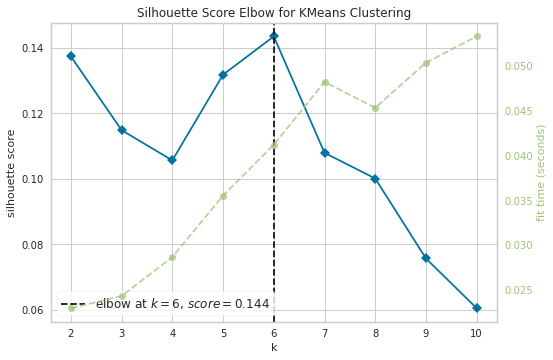

In [41]:
taipei_grouped_clustering = taipei_grouped.drop('Neighborhood', 1)
model=KMeans()
visualizer=KElbowVisualizer(model, K=(1,12), metric='silhouette')
visualizer.fit(taipei_grouped_clustering)
visualizer.show()

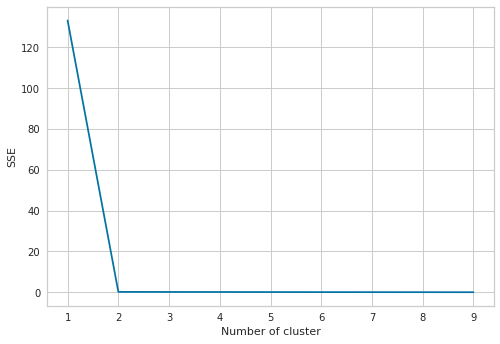

In [43]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(taipei_grouped_clustering)
    taipei_grouped_clustering["clusters"] = kmeans.labels_
    
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#### Run k-means to cluster the neighborhood into 2 clusters.

In [44]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(taipei_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

#### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels_2', kmeans.labels_)

taipei_merged = taipei_df

In [46]:
# merge taipei_grouped with taipei_data to add latitude/longitude for each neighborhood
taipei_merged = taipei_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

taipei_merged.head()

,Postal code,Neighborhood,Latitude,Longitude,Cluster Labels_2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,100,Zhongzheng District,25.032361,121.518267,1,Café,Noodle House,Convenience Store,Coffee Shop,Japanese Restaurant,Breakfast Spot,Dumpling Restaurant,History Museum,Hotpot Restaurant,Taiwanese Restaurant
1,103,Datong District,25.065986,121.515514,0,Taiwanese Restaurant,Convenience Store,Dessert Shop,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Park,Hotel,Hotpot Restaurant
2,104,Zhongshan District,25.064361,121.533468,1,Hotel,Taiwanese Restaurant,Convenience Store,Chinese Restaurant,Café,Hotpot Restaurant,Japanese Restaurant,BBQ Joint,Asian Restaurant,Seafood Restaurant
3,105,Songshan District,25.049885,121.577272,1,Convenience Store,Chinese Restaurant,Breakfast Spot,Taiwanese Restaurant,Park,Café,Asian Restaurant,Coffee Shop,Seafood Restaurant,Hotel
4,106,Daan District,25.026515,121.534395,1,Café,Noodle House,Coffee Shop,Taiwanese Restaurant,Tea Room,Ice Cream Shop,Chinese Restaurant,Dim Sum Restaurant,Dessert Shop,Bakery


### Create map to visualize the results

In [47]:
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install folium
import folium

     |████████████████████████████████| 94 kB 4.9 MB/s  eta 0:00:01


In [48]:
# create map
map_clusters = folium.Map(location=[25.0375198, 121.5636796], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(taipei_merged['Latitude'], taipei_merged['Longitude'], taipei_merged['Neighborhood'], taipei_merged['Cluster Labels_2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the 2 clusters

In [49]:
# Cluster 1
cluster_2_0 = taipei_merged.loc[taipei_merged['Cluster Labels_2'] == 0, taipei_merged.columns[[1] + list(range(5, taipei_merged.shape[1]))]]
cluster_2_0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Datong District,Taiwanese Restaurant,Convenience Store,Dessert Shop,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Park,Hotel,Hotpot Restaurant
5,Wanhua District,Taiwanese Restaurant,Convenience Store,Chinese Restaurant,Dessert Shop,Night Market,Coffee Shop,Asian Restaurant,Café,Hotel,Bakery
6,Xinyi District,Department Store,Hotel,Chinese Restaurant,Bar,Electronics Store,Café,Japanese Restaurant,Lounge,Coffee Shop,Noodle House
8,Beitou District,Hotel,Café,Convenience Store,Coffee Shop,Noodle House,Park,Asian Restaurant,Dessert Shop,Metro Station,Hot Spring
9,Neihu District,Convenience Store,Asian Restaurant,Taiwanese Restaurant,Hotel,Japanese Restaurant,Cafeteria,Burger Joint,Coffee Shop,Sporting Goods Shop,Golf Course
10,Nangang District,Convenience Store,Coffee Shop,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Shopping Mall,Breakfast Spot,Noodle House
11,Wenshan District,Coffee Shop,Convenience Store,Japanese Restaurant,Bus Station,Café,Pool,Cable Car,Chinese Restaurant,Sandwich Place,Sake Bar


In [50]:
# Cluster 2
cluster_2_1=taipei_merged.loc[taipei_merged['Cluster Labels_2'] == 1, taipei_merged.columns[[1] + list(range(5, taipei_merged.shape[1]))]]
cluster_2_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Zhongzheng District,Café,Noodle House,Convenience Store,Coffee Shop,Japanese Restaurant,Breakfast Spot,Dumpling Restaurant,History Museum,Hotpot Restaurant,Taiwanese Restaurant
2,Zhongshan District,Hotel,Taiwanese Restaurant,Convenience Store,Chinese Restaurant,Café,Hotpot Restaurant,Japanese Restaurant,BBQ Joint,Asian Restaurant,Seafood Restaurant
3,Songshan District,Convenience Store,Chinese Restaurant,Breakfast Spot,Taiwanese Restaurant,Park,Café,Asian Restaurant,Coffee Shop,Seafood Restaurant,Hotel
4,Daan District,Café,Noodle House,Coffee Shop,Taiwanese Restaurant,Tea Room,Ice Cream Shop,Chinese Restaurant,Dim Sum Restaurant,Dessert Shop,Bakery
7,Shilin District,Café,Convenience Store,Hotel,Food Court,Bubble Tea Shop,Noodle House,Taiwanese Restaurant,Ice Cream Shop,Food Truck,Japanese Restaurant


### Data Processing - 

In [51]:
taipei_venuecategory_number = taipei_venues.groupby(['Neighborhood','Venue Category']).count()
taipei_venuecategory_number.head()

Neighborhood Latitude  \
Neighborhood    Venue Category                            
Beitou District Art Museum                            1   
                Asian Restaurant                      2   
                Bookstore                             1   
                Bus Station                           1   
                Café                                  7   

                                  Neighborhood Longitude  Venue  \
Neighborhood    Venue Category                                    
Beitou District Art Museum                             1      1   
                Asian Restaurant                       2      2   
                Bookstore                              1      1   
                Bus Station                            1      1   
                Café                                   7      7   

                                  Venue Latitude  Venue Longitude  
Neighborhood    Venue Category                                     
Beitou District Art Museum                     1                1  
                Asian Restaurant               2                2  
                Bookstore                      1                1  
                Bus Station                    1                1  
                Café                           7                7

In [62]:
neighborhood_cluster_2_0=cluster_2_0['Neighborhood']
cluster_2_0_top_venuecate=set(cluster_2_0['1st Most Common Venue'])
venuecate_number={}

for x in cluster_2_0_top_venuecate:
    venuecate_number[x]=[]
venuecate_number   
    

{'Department Store': [],
 'Convenience Store': [],
 'Hotel': [],
 'Coffee Shop': [],
 'Taiwanese Restaurant': []}

In [63]:
for ven in cluster_2_0_top_venuecate:
    for nei in neighborhood_cluster_2_0:
        try:
            venuecate_number[ven].append(taipei_venuecategory_number.xs((nei,ven))['Venue'])
        except:
            continue
                                    
venuecate_number 

{'Department Store': [9, 1],
 'Convenience Store': [7, 6, 5, 5, 6, 5],
 'Hotel': [3, 2, 5, 8, 1, 2],
 'Coffee Shop': [4, 4, 3, 4, 1, 6, 5],
 'Taiwanese Restaurant': [11, 10, 2, 1, 2, 1]}

In [101]:
venuecate_2_0 = pd.DataFrame.from_dict(venuecate_number, orient='index')
venuecate_2_0

,0,1,2,3,4,5,6
Department Store,9,1,NaN,NaN,NaN,NaN,NaN
Convenience Store,7,6,5.0,5.0,6.0,5.0,NaN
Hotel,3,2,5.0,8.0,1.0,2.0,NaN
Coffee Shop,4,4,3.0,4.0,1.0,6.0,5.0
Taiwanese Restaurant,11,10,2.0,1.0,2.0,1.0,NaN


In [102]:
venuecate_2_0['Cluster_0'] = venuecate_2_0.sum(axis=1)
venuecate_2_0

,0,1,2,3,4,5,6,Cluster_0
Department Store,9,1,NaN,NaN,NaN,NaN,NaN,10.0
Convenience Store,7,6,5.0,5.0,6.0,5.0,NaN,34.0
Hotel,3,2,5.0,8.0,1.0,2.0,NaN,21.0
Coffee Shop,4,4,3.0,4.0,1.0,6.0,5.0,27.0
Taiwanese Restaurant,11,10,2.0,1.0,2.0,1.0,NaN,27.0


In [103]:
venuecate_2_0=venuecate_2_0[['Cluster_0']]
venuecate_2_0

,Cluster_0
Department Store,10.0
Convenience Store,34.0
Hotel,21.0
Coffee Shop,27.0
Taiwanese Restaurant,27.0


In [66]:
neighborhood_cluster_2_1=cluster_2_1['Neighborhood']
cluster_2_1_top_venuecate=set(cluster_2_1['1st Most Common Venue'])
venuecate_number_2_1={}

for x in cluster_2_1_top_venuecate:
    venuecate_number_2_1[x]=[]
venuecate_number_2_1 

{'Café': [], 'Convenience Store': [], 'Hotel': []}

In [67]:
for ven in cluster_2_1_top_venuecate:
    for nei in neighborhood_cluster_2_1:
        try:
            venuecate_number_2_1[ven].append(taipei_venuecategory_number.xs((nei,ven))['Venue'])
        except:
            continue
                                    
venuecate_number_2_1 

{'Café': [10, 6, 3, 17, 7],
 'Convenience Store': [8, 6, 11, 5],
 'Hotel': [11, 2, 2, 4]}

In [98]:
venuecate_2_1 = pd.DataFrame.from_dict(venuecate_number_2_1, orient='index')
venuecate_2_1

,0,1,2,3,4
Café,10,6,3,17,7.0
Convenience Store,8,6,11,5,NaN
Hotel,11,2,2,4,NaN


In [99]:
venuecate_2_1['Cluster_1'] = venuecate_2_1.sum(axis=1)
venuecate_2_1

,0,1,2,3,4,Cluster_1
Café,10,6,3,17,7.0,43.0
Convenience Store,8,6,11,5,NaN,30.0
Hotel,11,2,2,4,NaN,19.0


In [100]:
venuecate_2_1=venuecate_2_1[['Cluster_1']]
venuecate_2_1

,Cluster_1
Café,43.0
Convenience Store,30.0
Hotel,19.0


In [108]:
venuecate_2_0=venuecate_2_0.rename_axis('Venue Category').reset_index()

In [109]:
venuecate_2_0

,Venue Category,Cluster_0
0,Department Store,10.0
1,Convenience Store,34.0
2,Hotel,21.0
3,Coffee Shop,27.0
4,Taiwanese Restaurant,27.0


In [110]:
venuecate_2_1=venuecate_2_1.rename_axis('Venue Category').reset_index()

In [124]:
venuecate_2=pd.merge(venuecate_2_0, venuecate_2_1, how='outer', on='Venue Category')
venuecate_2

,Venue Category,Cluster_0,Cluster_1
0,Department Store,10.0,NaN
1,Convenience Store,34.0,30.0
2,Hotel,21.0,19.0
3,Coffee Shop,27.0,NaN
4,Taiwanese Restaurant,27.0,NaN
5,Café,NaN,43.0


In [125]:
venuecate_2.fillna(0, inplace=True)

In [127]:
venuecate_2=venuecate_2.set_index('Venue Category')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

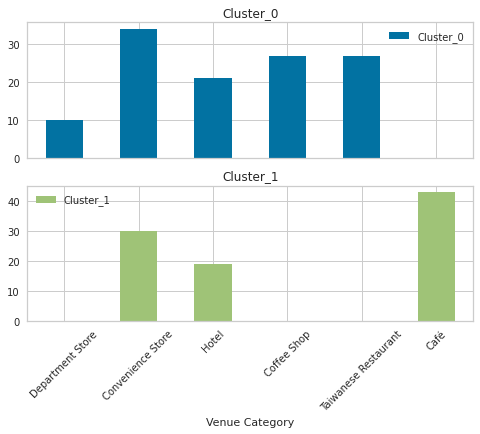

In [135]:
axes = venuecate_2.plot.bar(rot=0, subplots=True)
axes[1].legend(loc=2)
plt.xticks(rotation=45)

#### Run k-means to cluster the neighborhood into 6 clusters.

In [136]:
k = 6
kmeans_5 = KMeans(n_clusters=k, random_state=0).fit(taipei_grouped_clustering)
kmeans_5.labels_[0:10] 

array([4, 4, 2, 0, 5, 1, 3, 2, 0, 0], dtype=int32)

In [137]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels_6', kmeans_5.labels_)
taipei_merged = taipei_df
taipei_merged = taipei_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
taipei_merged.head()

,Postal code,Neighborhood,Latitude,Longitude,Cluster Labels_6,Cluster Labels_2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,100,Zhongzheng District,25.032361,121.518267,1,1,Café,Noodle House,Convenience Store,Coffee Shop,Japanese Restaurant,Breakfast Spot,Dumpling Restaurant,History Museum,Hotpot Restaurant,Taiwanese Restaurant
1,103,Datong District,25.065986,121.515514,2,0,Taiwanese Restaurant,Convenience Store,Dessert Shop,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Park,Hotel,Hotpot Restaurant
2,104,Zhongshan District,25.064361,121.533468,3,1,Hotel,Taiwanese Restaurant,Convenience Store,Chinese Restaurant,Café,Hotpot Restaurant,Japanese Restaurant,BBQ Joint,Asian Restaurant,Seafood Restaurant
3,105,Songshan District,25.049885,121.577272,3,1,Convenience Store,Chinese Restaurant,Breakfast Spot,Taiwanese Restaurant,Park,Café,Asian Restaurant,Coffee Shop,Seafood Restaurant,Hotel
4,106,Daan District,25.026515,121.534395,4,1,Café,Noodle House,Coffee Shop,Taiwanese Restaurant,Tea Room,Ice Cream Shop,Chinese Restaurant,Dim Sum Restaurant,Dessert Shop,Bakery


#### Create map to visualize the results

In [138]:
map_clusters_6 = folium.Map(location=[25.0375198, 121.5636796], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(taipei_merged['Latitude'], taipei_merged['Longitude'], taipei_merged['Neighborhood'], taipei_merged['Cluster Labels_6']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine the 5 clusters

In [157]:
# Cluster 1
cluster_5_0=taipei_merged.loc[taipei_merged['Cluster Labels_6'] == 0, taipei_merged.columns[[1] + list(range(5, taipei_merged.shape[1]))]].drop(['Cluster Labels_2'], axis=1)
cluster_5_0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Xinyi District,Department Store,Hotel,Chinese Restaurant,Bar,Electronics Store,Café,Japanese Restaurant,Lounge,Coffee Shop,Noodle House
10,Nangang District,Convenience Store,Coffee Shop,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Shopping Mall,Breakfast Spot,Noodle House
11,Wenshan District,Coffee Shop,Convenience Store,Japanese Restaurant,Bus Station,Café,Pool,Cable Car,Chinese Restaurant,Sandwich Place,Sake Bar


In [156]:
# Cluster 2
cluster_5_1=taipei_merged.loc[taipei_merged['Cluster Labels_6'] == 1, taipei_merged.columns[[1] + list(range(5, taipei_merged.shape[1]))]].drop(['Cluster Labels_2'], axis=1)
cluster_5_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Zhongzheng District,Café,Noodle House,Convenience Store,Coffee Shop,Japanese Restaurant,Breakfast Spot,Dumpling Restaurant,History Museum,Hotpot Restaurant,Taiwanese Restaurant
7,Shilin District,Café,Convenience Store,Hotel,Food Court,Bubble Tea Shop,Noodle House,Taiwanese Restaurant,Ice Cream Shop,Food Truck,Japanese Restaurant


In [155]:
# Cluster 3
cluster_5_2=taipei_merged.loc[taipei_merged['Cluster Labels_6'] == 2, taipei_merged.columns[[1] + list(range(5, taipei_merged.shape[1]))]].drop(['Cluster Labels_2'], axis=1)
cluster_5_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Datong District,Taiwanese Restaurant,Convenience Store,Dessert Shop,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Park,Hotel,Hotpot Restaurant
5,Wanhua District,Taiwanese Restaurant,Convenience Store,Chinese Restaurant,Dessert Shop,Night Market,Coffee Shop,Asian Restaurant,Café,Hotel,Bakery


In [154]:
# Cluster 4
cluster_5_3=taipei_merged.loc[taipei_merged['Cluster Labels_6'] == 3, taipei_merged.columns[[1] + list(range(5, taipei_merged.shape[1]))]].drop(['Cluster Labels_2'], axis=1)
cluster_5_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Zhongshan District,Hotel,Taiwanese Restaurant,Convenience Store,Chinese Restaurant,Café,Hotpot Restaurant,Japanese Restaurant,BBQ Joint,Asian Restaurant,Seafood Restaurant
3,Songshan District,Convenience Store,Chinese Restaurant,Breakfast Spot,Taiwanese Restaurant,Park,Café,Asian Restaurant,Coffee Shop,Seafood Restaurant,Hotel


In [152]:
# Cluster 5
cluster_5_4=taipei_merged.loc[taipei_merged['Cluster Labels_6'] == 4, taipei_merged.columns[[1] + list(range(5, taipei_merged.shape[1]))]].drop(['Cluster Labels_2'], axis=1)
cluster_5_4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Daan District,Café,Noodle House,Coffee Shop,Taiwanese Restaurant,Tea Room,Ice Cream Shop,Chinese Restaurant,Dim Sum Restaurant,Dessert Shop,Bakery
8,Beitou District,Hotel,Café,Convenience Store,Coffee Shop,Noodle House,Park,Asian Restaurant,Dessert Shop,Metro Station,Hot Spring


In [153]:
# Cluster 6
cluster_5_5=taipei_merged.loc[taipei_merged['Cluster Labels_6'] == 5, taipei_merged.columns[[1] + list(range(5, taipei_merged.shape[1]))]].drop(['Cluster Labels_2'], axis=1)
cluster_5_5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Neihu District,Convenience Store,Asian Restaurant,Taiwanese Restaurant,Hotel,Japanese Restaurant,Cafeteria,Burger Joint,Coffee Shop,Sporting Goods Shop,Golf Course
